On my way to Metis this Friday morning, I noticed the 6 train, which is normally a complete zoo at 8:30 am, was relatively calm. I'd like to investigate whether this was due to the upcoming holiday weeknd, or if this is just a general phenomena on Fridays.

My goal is to read in some of the turnstile data, and then clean it and arrange it so that I can investigate if there is a difference in the number of subway patrons on Mondays vs. Tuesdays vs. Wednesdays vs. Thursdays vs. Fridays during morning commuting time.

We want to have a big enough sample size so let's download 25 weeks of data. In order to avoid anomalies like holidays, I have selected 25 normal-seeming-holiday-free weeks from 2015 and 2016. I avoided weeks when there was a holiday the Friday or Weekend before, or the Monday after.

In [16]:
weeks = ['150815','150822','150829','150919','150926',
         '151003','151024','151121','151212','151219',
         '160130','160206','160227','160305','160312',
         '160326','160409','160416','160430','160507',
         '160514','160521','160611','160618','160625']

In [20]:
urls = ['''http://web.mta.info/developers/data/nyct/turnstile
        /turnstile_%s.txt''' % week for week in weeks]

In [19]:
!touch data.txt
for url in urls:
    !curl -s {url} >> data.txt

Reading it in and taking a look.

In [21]:
import pandas as pd
data = pd.read_csv('data.txt',low_memory=False)

In [22]:
data.columns = [col.strip() for col in data.columns]

In [23]:
print data.shape
print data.columns.tolist()
print data.head(3)

(4854895, 11)
['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME', 'DESC', 'ENTRIES', 'EXITS']
    C/A  UNIT       SCP        STATION LINENAME DIVISION        DATE  \
0  A002  R051  02-00-00  LEXINGTON AVE   NQR456      BMT  08/08/2015   
1  A002  R051  02-00-00  LEXINGTON AVE   NQR456      BMT  08/08/2015   
2  A002  R051  02-00-00  LEXINGTON AVE   NQR456      BMT  08/08/2015   

       TIME     DESC     ENTRIES  \
0  00:00:00  REGULAR  0005259242   
1  04:00:00  REGULAR  0005259278   
2  08:00:00  REGULAR  0005259291   

                                             EXITS  
0  0001779093                                       
1  0001779099                                       
2  0001779125                                       


Time is in four hour intervals (generally). The time listed is when a particular time interval ends. Entries, and Exits are cumulative counts. C/A - Control Area - and Unit are station identifiers. SCP is a turnstile identifier. Turnstiles are the most granular level of collection. [After a little research](https://github.com/bmander/mta-station-entrance-turnstile) a teammate of mine discovered that a unit can have up to four turnstiles. So we'll be able to uniquely identify a count by a Station-Unit-SCP tuple. Control Area will not be useful for us. Neither will Linename or Division or DESC so I will drop these.

In [24]:
data = data.drop(['C/A','LINENAME','DIVISION','DESC'],axis=1)

In [25]:
data.columns.tolist()

['UNIT', 'SCP', 'STATION', 'DATE', 'TIME', 'ENTRIES', 'EXITS']

Now we want to transform the cumulative counts for entries and exits into raw number of entries and exits. We will do so on the turnstile level. First things first let's make the Date and time columns into one column with a Datetime object in it. And just quickly before I do that, I will remove all the header rows of the data.

In [26]:
data = data.drop(data[data.DATE=='DATE'].index,axis=0)

In [27]:
from datetime import datetime, date, timedelta, time

In [28]:
data.insert(3,'datetime',[datetime.strptime(d+t,'%m/%d/%Y%X')
                          for d,t in zip(data.DATE,data.TIME)])
data = data.drop(['DATE','TIME'],axis=1)

In [29]:
data.head(3)

,UNIT,SCP,STATION,datetime,ENTRIES,EXITS
0,R051,02-00-00,LEXINGTON AVE,2015-08-08 00:00:00,0005259242,0001779093
1,R051,02-00-00,LEXINGTON AVE,2015-08-08 04:00:00,0005259278,0001779099
2,R051,02-00-00,LEXINGTON AVE,2015-08-08 08:00:00,0005259291,0001779125


Now let's investigate the length of these time intervals. Since the data that I grabbed is from many different weeks and the time intervals between different weeks might be unmeaningful because I might not have grabbed the data from the next week, I will start by inserting a week column that will be the number of weeks since 08/08/2015. Then I will group by this variable in addition to Unit and SCP and do a diff operation on the datetime column.

In [34]:
d_start = datetime.combine(date(2015,8,8), datetime.min.time())
sec_in_week = timedelta(weeks=1).total_seconds()

In [37]:
data.insert(4,'week',[int((dt.to_pydatetime() - d_start).total_seconds()/sec_in_week)
                      for dt in data.datetime])

In [38]:
print len(pd.unique(data.week))

25


In [39]:
print data.week.value_counts().head()

28    198884
5     196905
30    196533
25    195366
29    194776
Name: week, dtype: int64


In [40]:
data.insert(4,'dt_diffs',data.groupby(['UNIT','SCP','week'])['datetime'].transform(pd.Series.diff))
print data.dt_diffs.head()

0                   NaT
1   1970-01-01 04:00:00
2   1970-01-01 04:00:00
3   1970-01-01 04:00:00
4   1970-01-01 04:00:00
Name: dt_diffs, dtype: datetime64[ns]


The first value is 'NaT' which I guess stands for Not a Time. This is good. Now let's take a look at the values.

In [41]:
print data.dt_diffs.value_counts().head(3)

1970-01-01 04:00:00    4325736
1970-01-01 04:12:00     262177
1970-01-01 00:01:20       6222
Name: dt_diffs, dtype: int64


In [42]:
print (data.dt_diffs.value_counts()/len(data)).head(3)

1970-01-01 04:00:00    0.891009
1970-01-01 04:12:00    0.054003
1970-01-01 00:01:20    0.001282
Name: dt_diffs, dtype: float64


So, we can see that the data are messy. This is good information, but it actually should not matter for the question at hand. If we assume that the irregularities in the time intervals do not occur more or less often on any day of the week, we can just ignore this irregularity. To me this seems like a safe assumption so I will proceed under it. Now let's do a diff operation on the Cumulative entries and exits to see what the data look like.

In [43]:
data['ENTRIES'] = pd.to_numeric(data['ENTRIES'])
data.insert(len(data.columns),'ent_diffs',
            data.groupby(['UNIT','SCP','week'])['ENTRIES'].transform(pd.Series.diff))

In [44]:
data['EXITS'] = pd.to_numeric(data['EXITS'])
data.insert(len(data.columns),'ex_diffs',
            data.groupby(['UNIT','SCP','week'])['EXITS'].transform(pd.Series.diff))

In [45]:
data.head(3)

,UNIT,SCP,STATION,datetime,dt_diffs,week,ENTRIES,EXITS,ent_diffs,ex_diffs
0,R051,02-00-00,LEXINGTON AVE,2015-08-08 00:00:00,NaT,0,5259242,1779093,NaN,NaN
1,R051,02-00-00,LEXINGTON AVE,2015-08-08 04:00:00,1970-01-01 04:00:00,0,5259278,1779099,36.0,6.0
2,R051,02-00-00,LEXINGTON AVE,2015-08-08 08:00:00,1970-01-01 04:00:00,0,5259291,1779125,13.0,26.0


Let's check out the smallest values of both ent_diffs and ex_diffs.

In [47]:
print data.ent_diffs.sort_values().tolist()[0:3]
print data.ex_diffs.sort_values().tolist()[0:3]

[-2130765563.0, -1961790095.0, -1424900305.0]
[-2097169634.0, -1946115181.0, -1876058229.0]


There are negative diff values for both Entries and Exits. This makes no sense. Since we can't explain these values, I say we drop them from the set so they don't effect the analysis. Again this assumes that these negative values are not meaningful and further that any meaning they have is not different between different days of the week. Personally, I think this is reasonable. Short of calling an MTA official and asking him about the negative values, there's not much else I can do.

In [48]:
before = len(data)
data = data.drop(data[(data.ent_diffs<0) | (data.ex_diffs<0)].index, axis=0)
after = len(data)
shrinkage = float(before-after)/before * 100
print 'Data have been shrunk by %g %%' % shrinkage

Data have been shrunk by 0.936379 %


Now let's look at the other end of the spectrum to make sure the largest values are reasonable.

In [49]:
print data.ent_diffs.sort_values(ascending=False).tolist()[0:3]
print data.ex_diffs.sort_values(ascending=False).tolist()[0:3]

[2122354969.0, 1936970444.0, 1906771042.0]
[2088918757.0, 2022959610.0, 2004292012.0]


Those values are definitely not reasonable. Let's just make a quick assumption that no more than 14,400 people can exit or enter per turnstile in a given interval (that's one person per second for the four hour intervals).

In [50]:
before = len(data)
data = data.drop(data[(data.ent_diffs>14400) | (data.ex_diffs>14400)].index, axis=0)
after = len(data)
shrinkage = float(before-after)/before * 100
print 'Data have been shrunk by %g %%' % shrinkage

Data have been shrunk by 0.00261986 %


Now we are getting closer and closer to what we'll consider to be clean data. As a next step let's say the measure of overall traffic is entries plus exits. Also let's add a day of the week column, and drop all the columns we won't need from the point forward.

In [51]:
data['tot_traffic'] = data.ent_diffs + data.ex_diffs
data.insert(0,'day_of_week',[dt.weekday() for dt in data.datetime])
data = data[['datetime','week','day_of_week','tot_traffic']]

In [52]:
data.head() ## 5 is for Saturday

,datetime,week,day_of_week,tot_traffic
0,2015-08-08 00:00:00,0,5,NaN
1,2015-08-08 04:00:00,0,5,42.0
2,2015-08-08 08:00:00,0,5,39.0
3,2015-08-08 12:00:00,0,5,205.0
4,2015-08-08 16:00:00,0,5,280.0


Now we are only concerned with the morning commute time. Remember the time listed is for when the interval ends. Now I will select only the observations that correspond to the morning commute window. At the beginning I said I was interested in the time around 8:30 am. Getting that specific with these 4(ish) hour intervals is impossible. So I will subset the data to only intervals that end between 9 am and 12 pm (inclusive). This will capture all morning commuting times.

In [53]:
t_beg, t_end = time(9,0,0), time(12,0,0)
data.insert(1,'time',[dt.time() for dt in data.datetime])
data = data[(data.time>=t_beg) & (data.time<=t_end)]

In [55]:
data.head(3)

,datetime,time,week,day_of_week,tot_traffic
3,2015-08-08 12:00:00,12:00:00,0,5,205.0
9,2015-08-09 12:00:00,12:00:00,0,6,125.0
15,2015-08-10 12:00:00,12:00:00,0,0,415.0


Now we are ready to drop all but week, day_of_week, and tot_traffic. Then we can group by week and day_of_week and sum tot_traffic so that we just have 175 = 25 * 7 rows, one for each observed day.

In [56]:
data = data[['week','day_of_week','tot_traffic']]
grouped = data.groupby(['week','day_of_week'],as_index=False)

In [57]:
grouped.tot_traffic.sum().head(8)

,week,day_of_week,tot_traffic
0,0,0,2252447.0
1,0,1,2308394.0
2,0,2,2393093.0
3,0,3,2354279.0
4,0,4,2158339.0
5,0,5,904774.0
6,0,6,695501.0
7,1,0,2185417.0


I kept the weekends (day_of_week = 5 or 6) in up to this point just to see how the traffic values would compare to weekdays. Now we can see the weekend values are consistently about half to a third of the weekday values. Now I'll drop the weekend values so we can just focus on the task at hand.

In [58]:
nice_data = grouped.tot_traffic.sum()[~grouped.tot_traffic.sum().day_of_week.isin([5,6])]

In [59]:
nice_data.head(7)

,week,day_of_week,tot_traffic
0,0,0,2252447.0
1,0,1,2308394.0
2,0,2,2393093.0
3,0,3,2354279.0
4,0,4,2158339.0
7,1,0,2185417.0
8,1,1,2278765.0


It'd be nice to make each week a row and each day of the week a column with tot_traffic in each cell. 

In [60]:
nice_data = nice_data.pivot(index='week', columns='day_of_week', values='tot_traffic')

In [61]:
nice_data.iloc[0:5]

day_of_week,0,1,2,3,4
week,,,,,
0,2252447.0,2308394.0,2393093.0,2354279.0,2158339.0
1,2185417.0,2278765.0,2319063.0,2231249.0,2080025.0
2,2192734.0,2289553.0,2294883.0,2274809.0,2132043.0
5,2113839.0,2254451.0,2654572.0,2656529.0,2503096.0
6,2649754.0,2566864.0,2136313.0,2451108.0,2467842.0


Now we can hypothesis test whether the mean of Mondays is different from the mean of Tuesdays and mean of Wednesdays as so on. First lets visualize the data a little.

In [62]:
import matplotlib.pyplot as plt
%matplotlib inline

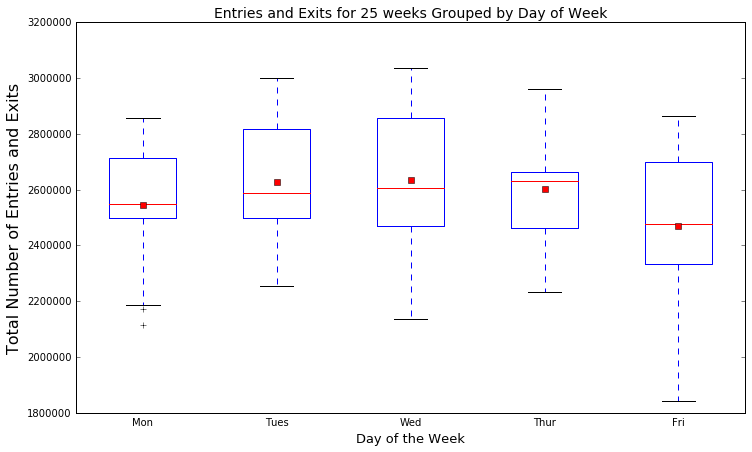

In [63]:
plt.figure(figsize=(12,7))
plt.boxplot([nice_data[col] for col in nice_data.columns.tolist()], showmeans=True);
plt.xticks(nice_data.columns + 1, ['Mon','Tues','Wed','Thur','Fri']);
plt.tick_params(top='off',bottom='off');
plt.ylabel('Total Number of Entries and Exits',fontsize=16);
plt.xlabel('Day of the Week',fontsize=13);
plt.title('Entries and Exits for 25 weeks Grouped by Day of Week',fontsize=14);

The means are the dots and the medians are the lines. The Friday values do seems to be smaller.

Alright, now let's do some sort of test to see if the mean of total riders is different for Mondays versus Tuesdays versus Wednesday, etc. The Monday mean seems a little small and the Friday mean seems a little small as we saw in the graph. Here are the means as numbers:

In [64]:
[nice_data[col].mean() for col in nice_data.columns]

[2545633.6, 2626041.8, 2633699.44, 2600615.8, 2468463.56]

The means do seem to be different, but how likely is it that this difference is due to random chance?

I can think of at least two different roads to investigate this. The first is this:
* Pool all the observations from all groups.
* Draw random samples without replacement of the size of the group that you are interested in.
* Keep track of how many of the means of the random samples are as different as the mean of the group.

For these data, this means drawing samples of size 25 from the population of all days of the week and observing the distribution of means of the samples and comparing them to the means for each day of the week.

In [65]:
import numpy as np

In [66]:
def draw_samples(population,size,iters):
    means = []
    for _ in xrange(iters):
        mean = np.mean(np.random.choice(population,size,replace=False))
        means.append(mean)
    return means

In [67]:
means = draw_samples(np.ravel(nice_data),25,10000)

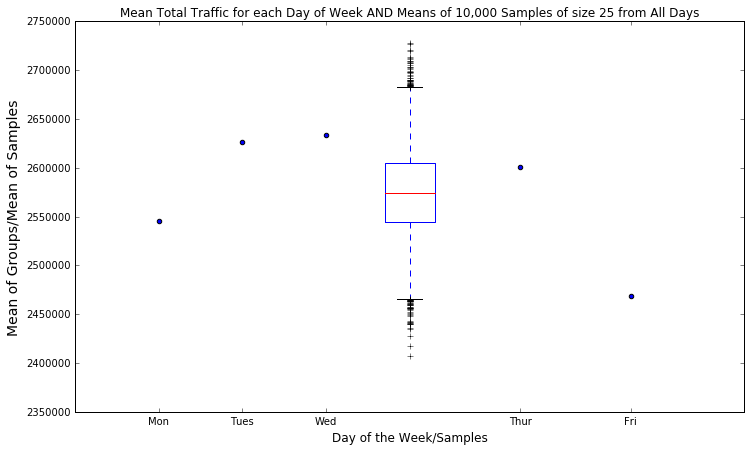

In [68]:
fig, ax = plt.subplots(figsize=(12,7))
plt.boxplot(means,whis=[.5, 99.5]);
plt.xticks([.25,.5,.75,1.33,1.66], ['Mon','Tues','Wed','Thur','Fri']);
plt.scatter([.25,.5,.75,1.33,1.66],[nice_data[col].mean() for col in nice_data.columns])
ax.set_xlim([0, 2]);
plt.ylabel('Mean of Groups/Mean of Samples',fontsize=14);
plt.xlabel('Day of the Week/Samples',fontsize=12);
plt.title('Mean Total Traffic for each Day of Week AND Means of 10,000 Samples of size 25 from All Days');

I've set the whiskers of the boxplot to enclose 99% of the means. As you can see, the mean of the Fridays seems to fall just barely inside this threshold. This indicates it's very unlikely that the mean that presents in the Friday group could occur in a distribution of means of random samples drawn from the whole population of weekdays. Not impossible, but unlikely. Exactly how likely you may ask?

In [69]:
liklihood = float(sum(1 for mean in means if mean<nice_data[4].mean())) / len(means)
print liklihood

0.0058


Now, let's do this one other way. Instead of a pool then sample method, I'll use resampling. Since I am investigating the difference in each day of the week's ridership to the average weekday, I'll use this strategy:

* Subtract the week's average ridership from the observed riderships of each weekday.
* Resample each of the 25 groups with replacement.
* Observe the distributions.

In [70]:
minus_the_mean = pd.DataFrame(nice_data.values - np.array([[mean] for mean in nice_data.mean(1)]))

In [71]:
minus_the_mean.head()

,0,1,2,3,4
0,-40863.4,15083.6,99782.6,60968.6,-134971.4
1,-33486.8,59861.2,100159.2,12345.2,-138878.8
2,-44070.4,52748.6,58078.6,38004.6,-104761.4
3,-322658.4,-182046.4,218074.6,220031.6,66598.6
4,195377.8,112487.8,-318063.2,-3268.2,13465.8


In [72]:
def resample(sample,iters):
    means = []
    for _ in xrange(iters):
        mean = np.mean(np.random.choice(sample,len(sample),replace=True))
        means.append(mean)
    return means

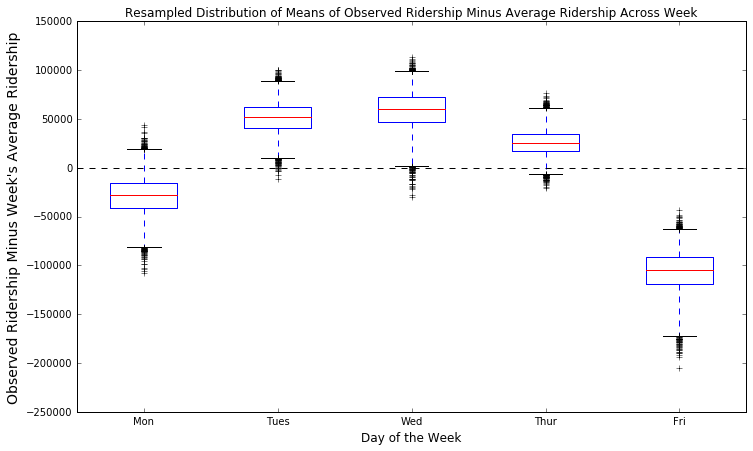

In [73]:
fig, ax = plt.subplots(figsize=(12,7));
plt.boxplot([resample(minus_the_mean[col],10000) for col in range(5)],whis=[.5, 99.5]);
plt.axhline(0,ls='--',color='black')
plt.xticks(range(1,6), ['Mon','Tues','Wed','Thur','Fri']);
plt.ylabel("Observed Ridership Minus Week's Average Ridership",fontsize=14);
plt.xlabel('Day of the Week',fontsize=12);
plt.title('Resampled Distribution of Means of Observed Ridership Minus Average Ridership Across Week');

From this method, we can say definitively that the number of Riders on Fridays is different than the average number of riders during the week as a whole. There is an indication that Monday's might be below average but we can't say for sure.